<a href="https://colab.research.google.com/github/nuel071003/MK-Deep-Learning/blob/main/Klasifikasi_Sayuran.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Import Necessary Libraries

In [31]:
!pip install -q torch torchvision scikit-learn matplotlib seaborn

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import cv2

2. Load and Transform Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
# ... (rest of your imports)

def get_image_df(root_dir):
    IMG_EXT = ('.jpg', '.jpeg', '.png')
    data = []
    for label in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, label)
        if os.path.isdir(class_dir):
            for fname in os.listdir(class_dir):
                if fname.lower().endswith(IMG_EXT):
                    data.append({'Filepath': os.path.join(class_dir, fname), 'Label': label})
    return pd.DataFrame(data)

# Call the function with the path to your dataset
image_df = get_image_df('/content/drive/MyDrive/Sayuran') # Make sure the path is correct

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


3. Placing Data into a Dataframe

In [ ]:
image_df = image_df.sample(frac=1, random_state=42).reset_index(drop=True)
print(image_df.head())

                                            Filepath       Label
0  /content/drive/MyDrive/Sayuran/Wortel/IMG-2025...      Wortel
1  /content/drive/MyDrive/Sayuran/Terong/aug_0_44...      Terong
2  /content/drive/MyDrive/Sayuran/Bayam/spinach82...       Bayam
3  /content/drive/MyDrive/Sayuran/Sawi Putih/Chin...  Sawi Putih
4  /content/drive/MyDrive/Sayuran/Bayam/spinach97...       Bayam


4. Visualizing images from the dataset

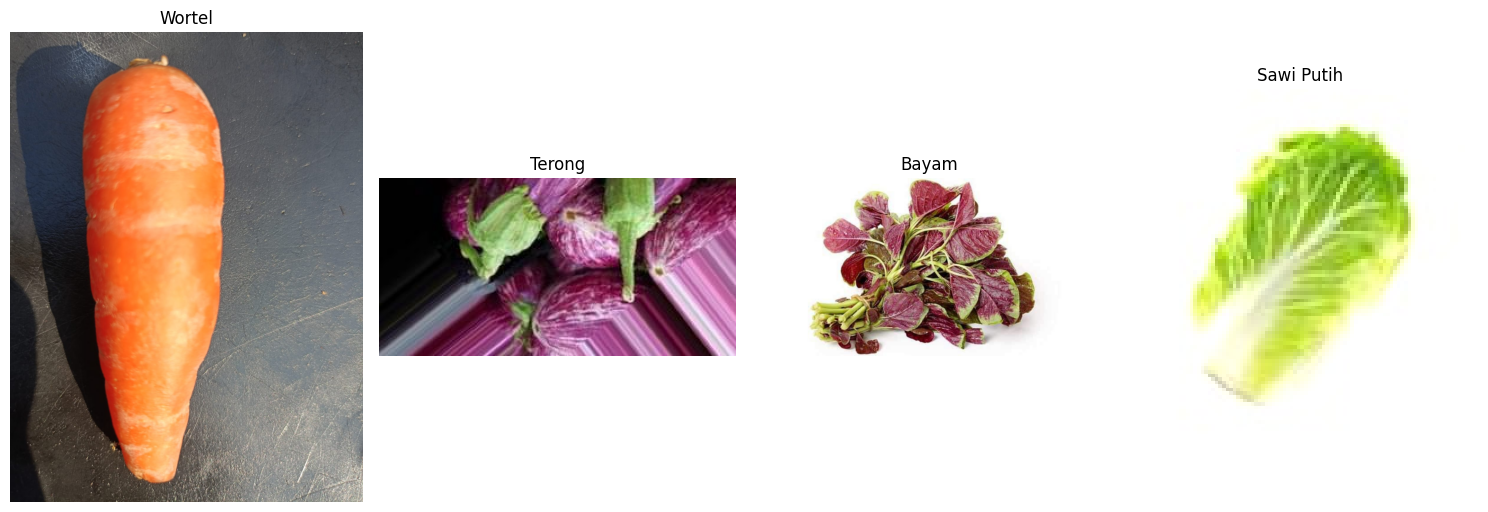

In [ ]:
# 4# Visualizing images from the dataset (satu gambar per kelas)
unique_labels = image_df['Label'].unique()
fig, axes = plt.subplots(1, len(unique_labels), figsize=(15, 5))

for idx, label in enumerate(unique_labels):
    img_path = image_df[image_df['Label'] == label].iloc[0]['Filepath']
    img = Image.open(img_path)
    axes[idx].imshow(img)
    axes[idx].set_title(label)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

5. Computing Error Rate Analysis

In [ ]:
import os
from PIL import Image, ImageChops, ImageEnhance
from pathlib import Path

# Folder input dan output
input_root = "/content/drive/MyDrive/Sayuran"
output_root = "/content/drive/MyDrive/Sayuran"
ela_quality = 90  # Kompresi kualitas JPEG untuk ELA

def convert_to_ela_and_save(input_path, output_path, quality=ela_quality):
    temp_filename = "temp_ela.jpeg"
    image = Image.open(input_path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality=quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0: max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    ela_image.save(output_path)

# Proses semua gambar di setiap kelas
classes = os.listdir(input_root)

for class_name in classes:
    input_class_dir = os.path.join(input_root, class_name)
    output_class_dir = os.path.join(output_root, class_name)

    if not os.path.isdir(input_class_dir):
        continue

    for img_file in os.listdir(input_class_dir):
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            input_path = os.path.join(input_class_dir, img_file)
            output_path = os.path.join(output_class_dir, f"ELA_{img_file}")
            try:
                convert_to_ela_and_save(input_path, output_path)
                print(f"[✓] ELA saved: {output_path}")
            except Exception as e:
                print(f"[X] Failed: {input_path} - {str(e)}")

[✓] ELA saved: /content/drive/MyDrive/Sayuran/Bayam/ELA_spinach924.jpg
[✓] ELA saved: /content/drive/MyDrive/Sayuran/Bayam/ELA_spinach929.jpg
[✓] ELA saved: /content/drive/MyDrive/Sayuran/Bayam/ELA_spinach926.jpg
[✓] ELA saved: /content/drive/MyDrive/Sayuran/Bayam/ELA_spinach925.jpg
[✓] ELA saved: /content/drive/MyDrive/Sayuran/Bayam/ELA_spinach923.jpg
[✓] ELA saved: /content/drive/MyDrive/Sayuran/Bayam/ELA_spinach920.jpg
[✓] ELA saved: /content/drive/MyDrive/Sayuran/Bayam/ELA_spinach928.jpg
[✓] ELA saved: /content/drive/MyDrive/Sayuran/Bayam/ELA_spinach922.jpg
[✓] ELA saved: /content/drive/MyDrive/Sayuran/Bayam/ELA_spinach921.jpg
[✓] ELA saved: /content/drive/MyDrive/Sayuran/Bayam/ELA_spinach927.jpg
[✓] ELA saved: /content/drive/MyDrive/Sayuran/Bayam/ELA_spinach930.jpg
[✓] ELA saved: /content/drive/MyDrive/Sayuran/Bayam/ELA_spinach933.jpg
[✓] ELA saved: /content/drive/MyDrive/Sayuran/Bayam/ELA_spinach936.jpg
[✓] ELA saved: /content/drive/MyDrive/Sayuran/Bayam/ELA_spinach931.jpg
[✓] EL

6. Data Preprocessing

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import os

# DataFrame dari folder dataset
dataset_path = '/content/drive/MyDrive/Sayuran'
labels = os.listdir(dataset_path)
image_paths = []
image_labels = []

for label in labels:
    class_folder = os.path.join(dataset_path, label)
    if os.path.isdir(class_folder):
        for fname in os.listdir(class_folder):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(class_folder, fname))
                image_labels.append(label)

image_df = pd.DataFrame({
    'Filepath': image_paths,
    'Label': image_labels
})

# Split test set terlebih dahulu (5%)
train_val_df, test_df = train_test_split(
    image_df,
    test_size=0.05,
    shuffle=True,
    random_state=42,
    stratify=image_df['Label']
)

# 25/95 ≈ 0.263
val_size = 25 / 95

train_df, val_df = train_test_split(
    train_val_df,
    test_size=val_size,
    shuffle=True,
    random_state=42,
    stratify=train_val_df['Label']
)

# Konfirmasi ukuran
print(f"Jumlah data latih: {len(train_df)}")
print(f"Jumlah data validasi: {len(val_df)}")
print(f"Jumlah data uji: {len(test_df)}")

# Hitung jumlah gambar per kelas
print("\nJumlah gambar per kelas pada data latih:")
print(train_df.groupby('Label').size())

print("\nJumlah gambar per kelas pada data validasi:")
print(val_df.groupby('Label').size())

print("\nJumlah gambar per kelas pada data pengujian:")
print(test_df.groupby('Label').size())

# Target size dan batch size
TARGET_SIZE = (128, 128)
BATCH_SIZE = 32

# Augmentasi untuk training
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2]
)

# Untuk validasi dan testing (tanpa augmentasi)
val_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

# Flow dari dataframe
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_images = val_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)




Jumlah data latih: 1680
Jumlah data validasi: 600
Jumlah data uji: 120

Jumlah gambar per kelas pada data latih:
Label
Bayam         420
Sawi Putih    420
Terong        420
Wortel        420
dtype: int64

Jumlah gambar per kelas pada data validasi:
Label
Bayam         150
Sawi Putih    150
Terong        150
Wortel        150
dtype: int64

Jumlah gambar per kelas pada data pengujian:
Label
Bayam         30
Sawi Putih    30
Terong        30
Wortel        30
dtype: int64
Found 1680 validated image filenames belonging to 4 classes.
Found 600 validated image filenames belonging to 4 classes.
Found 120 validated image filenames belonging to 4 classes.


7. Training the model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam
import datetime
import os


In [ ]:
# Muat model ResNet50 sebagai backbone
resnet_base = ResNet50(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    pooling=None  # gunakan GAP nanti
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# Bekukan semua layer pretrained agar tidak di-train ulang
resnet_base.trainable = False

# Callback Checkpoint
checkpoint_path = "sayuran_resnet50.weights.h5"
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
)

# EarlyStopping & ReduceLROnPlateau
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)


In [30]:
# TensorBoard logging
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = os.path.join(dir_name, experiment_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return TensorBoard(log_dir=log_dir)

# Bangun model klasifikasi sayuran
inputs = Input(shape=(128, 128, 3))
x = tf.keras.applications.resnet.preprocess_input(inputs)
x = resnet_base(x)
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.6)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)
outputs = Dense(len(train_images.class_indices), activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# Kompilasi model
model.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Jalankan training
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        early_stopping,
        reduce_lr,
        checkpoint_callback,
        create_tensorboard_callback("training_logs", "sayuran_resnet50")
    ]
)

Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - accuracy: 0.2675 - loss: 1.5367 - val_accuracy: 0.2850 - val_loss: 1.3839 - learning_rate: 5.0000e-05
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - accuracy: 0.2497 - loss: 1.4825 - val_accuracy: 0.3017 - val_loss: 1.3813 - learning_rate: 5.0000e-05
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.2577 - loss: 1.4859 - val_accuracy: 0.2617 - val_loss: 1.3782 - learning_rate: 5.0000e-05
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.2574 - loss: 1.4569 - val_accuracy: 0.3183 - val_loss: 1.3760 - learning_rate: 5.0000e-05
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.2926 - loss: 1.4090 - val_accuracy: 0.2883 - val_loss: 1.3730 - learning_rate: 5.0000e-05
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 207s 3s/step - accuracy: 0.2789 - loss: 1.4093 - val_accuracy: 0.3383 - val_loss: 1.3689 - learning_rate: 5.0000e-05
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.2403 

8. Model Evaluation

In [44]:
test_loss, test_accuracy = model.evaluate(test_images, steps=len(test_images)) # Fixed typo: est_loss to test_loss

print(f"\nEvaluasi Model pada Data Uji:")
print(f"- Test Loss    : {test_loss:.4f}")
print(f"- Test Accuracy: {test_accuracy:.2f}%")


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.6194 - loss: 1.0077

Evaluasi Model pada Data Uji:
- Test Loss    : 1.0374
- Test Accuracy: 0.61%


9. Visualizing loss curves

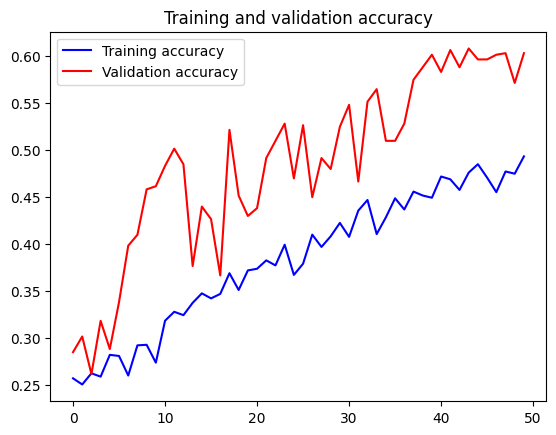

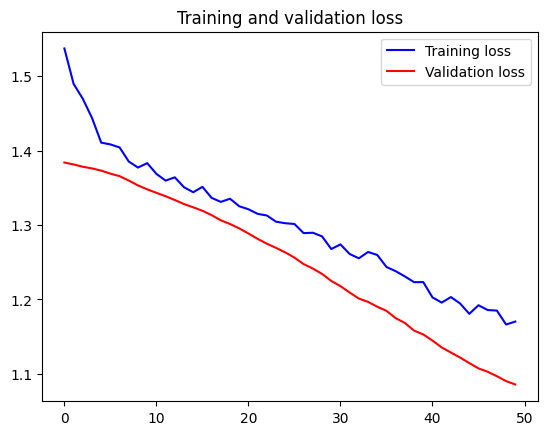

In [46]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

10. Making Predictions on the Test Data

In [54]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_single_image(img_path, model, class_indices, true_label=None, target_size=(128, 128)):
    # Load & preprocess image
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.resnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction[0])

    # Mapping index ke label
    label_map = {v: k for k, v in class_indices.items()}
    predicted_label = label_map[predicted_class_index]

    # Tampilkan gambar
    plt.imshow(img)
    plt.axis('off')

    # Tambahkan judul: prediksi vs label asli
    if true_label:
        if predicted_label == true_label:
            title_color = "green"
        else:
            title_color = "red"
        plt.title(f"Label Asli: {true_label} | Prediksi: {predicted_label}", color=title_color)
    else:
        plt.title(f"Prediksi: {predicted_label}")

    plt.show()
    return predicted_label


In [56]:
# Predict label test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Petakan label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step


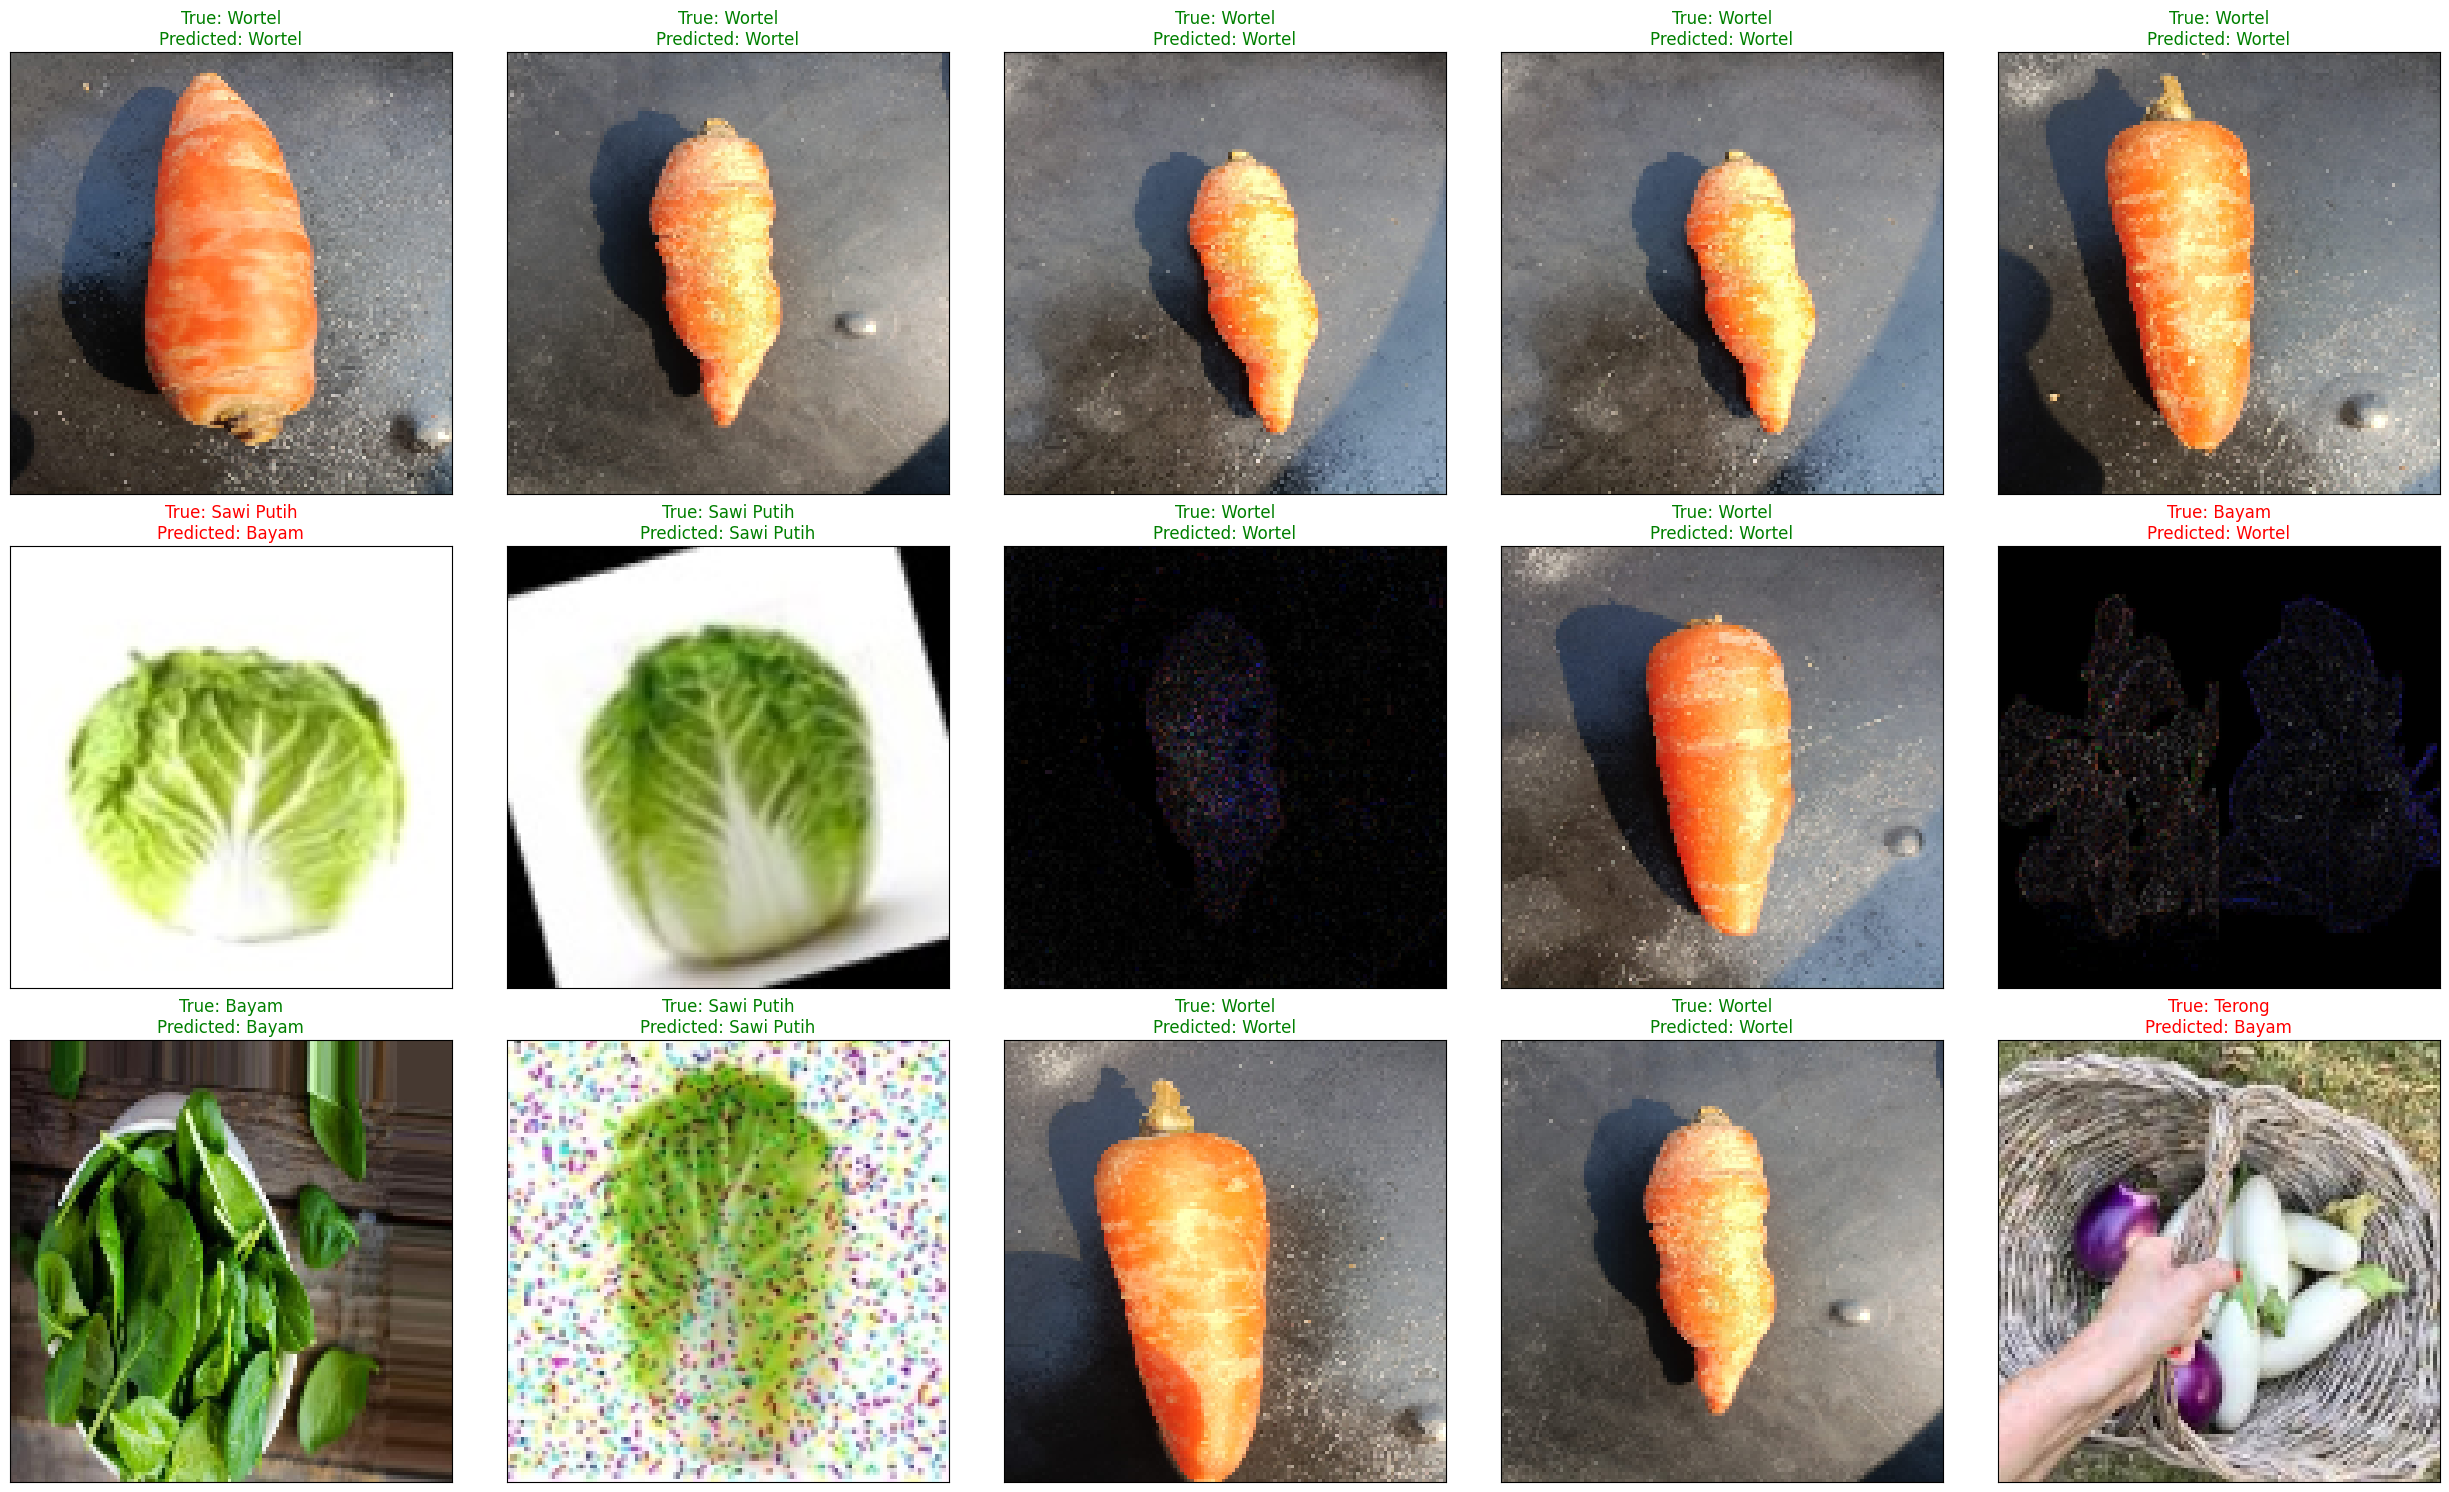

In [57]:
# Menampilkan 25 gambar acak dari dataset dengan labelnya
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

resize_dim = (128, 128)

for i, ax in enumerate(axes.flat):
    img = plt.imread(test_df.Filepath.iloc[random_index[i]])
    img_resized = cv2.resize(img, resize_dim)
    ax.imshow(img_resized)

    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"

    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)

plt.tight_layout()
plt.show()

11. Grad-CAM Visualization Untuk ResNet50 di TensorFlow

In [152]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(image_df['Label'].unique()))  # Sesuaikan output class
model = model.to(device)
model.eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 123MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [153]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1)

        self.model.zero_grad()
        output[0, class_idx].backward()

        gradients = self.gradients[0]
        activations = self.activations[0]
        weights = torch.mean(gradients, dim=(1, 2))

        cam = torch.zeros(activations.shape[1:], dtype=torch.float32).to(device)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = torch.relu(cam)
        cam -= cam.min()
        cam /= cam.max()
        return cam.cpu().numpy()


In [154]:
def show_gradcam(image_path, cam, alpha=0.5):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    cam = cv2.resize(cam, (224, 224))

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    superimposed_img = heatmap * alpha + np.float32(img) / 255
    superimposed_img = np.clip(superimposed_img, 0, 1)

    plt.imshow(superimposed_img)
    plt.axis('off')


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


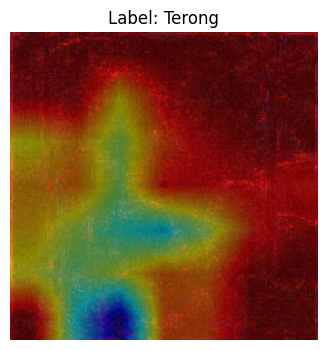

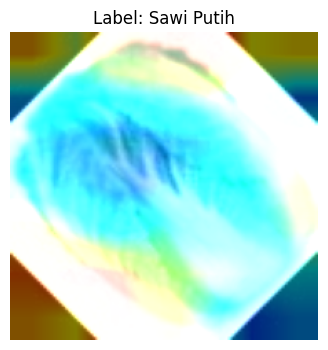

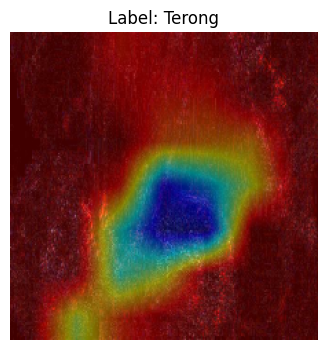

In [155]:
# Transformasi sama seperti saat training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Ambil layer terakhir di ResNet50 (yang menghasilkan feature maps)
target_layer = model.layer4[-1]
cam_generator = GradCAM(model, target_layer)

# Tampilkan Grad-CAM untuk 3 gambar
samples = image_df.sample(3).reset_index(drop=True)

for i in range(len(samples)):
    img_path = samples.loc[i, 'Filepath']
    img = Image.open(img_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)

    cam = cam_generator.generate_cam(input_tensor)
    plt.figure(figsize=(4, 4))
    plt.title(f"Label: {samples.loc[i, 'Label']}")
    show_gradcam(img_path, cam)
    plt.show()
